# The SVHN number detection 

This is a notebook implementation of SVHN digit detector for homework 3 of the Computer Vision course. 

## Prequisites
Mount Google Drive for downloaing, uploading files

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
save_dir = 'filt5_6layer_32_64_128_128_256_512'
save_run_path = '/content/drive/My Drive/Colab Notebooks/ComputerVision/HW3/Results/'+save_dir
TrainMode = True

In [0]:
import numpy as np
import cv2
import random


%tensorflow_version 1.x
import tensorflow as tf
import matplotlib.pyplot as plt

import os
import shutil

# Tensorflow warnings off
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import time
import pickle
from datetime import timedelta
import pdb



TensorFlow 1.x selected.


## Loading the data

Load the processed 32x32 SVHN dataset of format 2 ``SVHN_gray.pickle``

In [0]:
if not 'X_train0' in locals():

  # Path to the SVHN data
  PATH = '/content/drive/My Drive/Colab Notebooks/ComputerVision/HW3/Preprocessed/Data_format2/SVHN_gray.pickle'

  # Load the training, test and validation set
  with open(PATH, 'rb') as pick_file:
    data = pickle.load(pick_file)
    X_train0 = data['X_train']
    y_train = data['y_train']
    X_test0 = data['X_test']
    y_test = data['y_test']
    X_val0 = data['X_val']
    y_val = data['y_val']

    del data

print('Training set', X_train0.shape, y_train.shape)
print('Validation set', X_val0.shape, y_val.shape)
print('Test set', X_test0.shape, y_test.shape)


#### Post-processing

Postprocessing the images (normalization, cropping, etc.)

In [0]:
# Normalize the data (subtract mean and divide by std)
X_train_mean = np.mean(X_train0, axis=0)
X_train_std = np.std(X_train0, axis=0)

X_train = (X_train0 - X_train_mean) / X_train_std
X_test = (X_test0 - X_train_mean)  / X_train_std
X_val = (X_val0 - X_train_mean) / X_train_std


In [0]:
# Gaussian kernel to mask the image
kernel_x = cv2.getGaussianKernel(31, 23)
kernel_y = cv2.getGaussianKernel(31, 7)
kernel_x = np.vstack((kernel_x, kernel_x[-1]))/np.max(kernel_x)
kernel_y = np.vstack((kernel_y, kernel_y[-1]))/np.max(kernel_y)
kernel_gauss_2d = np.matmul(kernel_x, kernel_y.transpose())


In [0]:
# Function for masking 32x32 images with a elliptic Gaussian kernel (output 32x32)
def Gaussian_filter (Data, kernel_2d):
  Data_out = np.zeros((Data.shape[0],Data.shape[1],Data.shape[2],1), dtype = 'float32')
  for i in range(Data.shape[0]):
    if (Data.shape[3]>1) :
      img_gray = cv2.cvtColor(Data[i,:,:,:], cv2.COLOR_RGB2GRAY)
    else:
      img_gray = Data[i,:,:,0]

    img_kernel_g = np.multiply(img_gray,kernel_2d)
    Data_out[i,:,:,:] = np.expand_dims(img_kernel_g, axis=2)
    return Data_out


# Function for cropping 32x32 images to smaller size (output hxw)
def crop(Data, crop_size):
  [h,w] = crop_size
  Data_out = np.zeros((Data.shape[0],h,w,1), dtype = Data.dtype)
  for i in range(Data.shape[0]):
    if (Data.shape[3]>1) :
      img_gray = cv2.cvtColor(Data[i,:,:,:], cv2.COLOR_RGB2GRAY)
    else:
      img_gray = Data[i,:,:,0]
    cp = int(Data.shape[1]/2)
    hhalf = int(h/2)
    whalf = int(w/2)
    img_crop = img_gray[cp-hhalf:cp+h-hhalf, cp-whalf:cp+w-whalf]
    Data_out[i,:,:,:] = np.expand_dims(img_crop, axis=2)
    return Data_out

# Function for zero-padded cropping of 32x32 images (output 32x32)
def crop_zero(Data, crop_size):
  [h,w] = crop_size
  Data_out = np.zeros_like(Data)
  for i in range(Data.shape[0]):
    if (Data.shape[3]>1) :
      img_gray = cv2.cvtColor(Data[i,:,:,:], cv2.COLOR_RGB2GRAY)
    else:
      img_gray = Data[i,:,:,0]
    cp = int(Data.shape[1]/2)
    hhalf = int(h/2)
    whalf = int(w/2)
    img_crop_zero = Data_out[i,:,:,0]
    img_crop_zero[cp-hhalf:cp+h-hhalf, cp-whalf:cp+w-whalf] = img_gray[cp-hhalf:cp+h-hhalf, cp-whalf:cp+w-whalf]
    Data_out[i,:,:,:] = np.expand_dims(img_crop_zero, axis=2)
    return Data_out
    

In [0]:
## Mask each 32x32 image with Gaussian kernel
# X_train = Gaussian_filter(X_train, kernel_gauss_2d)
# X_test = Gaussian_filter(X_test, kernel_gauss_2d)
# X_val = Gaussian_filter(X_val, kernel_gauss_2d)



In [0]:
## Crop each 32x32 image to 32x20
# crop_size = (32,20)
# X_train = crop(X_train, crop_size)
# X_test = crop(X_test, crop_size)
# X_val = crop(X_val, crop_size)


 Get the dimensions of the processed dataset

In [0]:
N_train, img_h, img_w , n_channels = X_train.shape

# number of classes (10)
n_classes = y_train.shape[-1]

### Plot

Helper function for plotting randomly sampled images

In [0]:
# Plot randomly sampled images 
def plot_sample_images(images, nrows, ncols, label_true=None, label_pred=None):

    fig, axes = plt.subplots(nrows, ncols, figsize=(10,5))
    
    # Random samples 
    randIdx = np.random.choice(images.shape[0], nrows*ncols)
    
    for i, ax in zip(randIdx, axes.flat): 
        
        if i<images.shape[0]:
          # No labels 
          if label_true is None:
              title = " "

          # No predictions 
          elif label_pred is None:
              title = "True: {0}".format(np.argmax(label_true[i]))
          
          # With predicted labels
          else:
              title = "True: {0}, Pred: {1}".format(np.argmax(label_true[i]), label_pred[i])  

          if len(images.shape)>3:  
            ax.imshow(images[i,:,:,0],'gray')
          else:
            ax.imshow(images[i,:,:],'gray')

          ax.set_title(title)
          ax.get_xaxis().set_visible(False)
          ax.get_yaxis().set_visible(False)
        
        

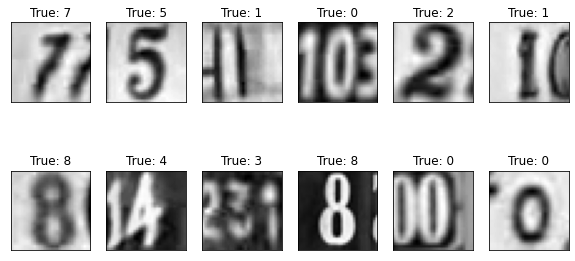

In [0]:
plot_sample_images(X_train, 2, 6, y_train);


## Build Model

Here we build our CNN network using conv, max-pool, batch-normalization and fully-connected layers. We also apply dropout to some intermediate layers. 

### Model auxiliary functions  


The followings are auxiliary functions required to define conv, max-pool and fully-connected layers.

In [0]:
# conv layer function
def conv2d_layer(x,                 # input  
                filter_size,        # filter size
                in_channel_size,    # no. input channels
                out_channel_size,   # no. output channels
                name,               # layer name 
                stride = 1          # stride
                ):      
   

    shape_W = [filter_size, filter_size, in_channel_size, out_channel_size]
    name_W = 'Weight_'+name
    W = tf.get_variable(name=name_W, shape=shape_W, initializer=tf.contrib.layers.xavier_initializer_conv2d())
    
    # pdb.set_trace()

    name_B = 'bias_'+name
    B = tf.Variable(tf.constant(0.0, shape=[out_channel_size]), name=name_B)
    
    y = tf.nn.conv2d(x,
                         filter=W,
                         strides=[1, stride, stride, 1],
                         padding='SAME') 

    y = tf.nn.bias_add(y, B)
    
    # RELU
    y = tf.nn.relu(y)

    # Return output, weights and biases
    return y, W, B

In [0]:
# max-pool function
def maxpool2d_layer(x, k=2, s=2):
    return tf.nn.max_pool(x, ksize=[1, k, k, 1], strides=[1, s, s, 1], padding='SAME')

In [0]:
def fc_layer(x,            # input
             num_inputs,   # no. input channels
             num_outputs,  # no. output channels                         
             name,         # layer name
             relu=True,    # apply relu or not
             ):   

    shape_W = [num_inputs, num_outputs]

    name_W = 'Weight_'+name
    W = tf.get_variable(name=name_W, shape=shape_W, initializer=tf.contrib.layers.xavier_initializer())
    
    name_B = 'bias_'+name
    B = tf.Variable(tf.constant(0.0, shape=[num_outputs]), name=name_B)


    y =  tf.nn.xw_plus_b(x, W, B)

    # apply RELU?
    if relu:
        y = tf.nn.relu(y)

    return y, W, B

In [0]:
# flattening layer function
def flatten(x):

    x_shape = x.get_shape()

    # number of features: height * width * num_channels
    n_features = x_shape[1]*x_shape[2]*x_shape[3]
    x_flattened = tf.reshape(x, [-1, n_features])

    return x_flattened, n_features

In [0]:
# First reset the model graph
tf.reset_default_graph()


### Input Variables

We define some placeholder variables as inputs.

In [0]:
# Image (32x32 pixel) input
x = tf.placeholder(tf.float32, shape=(None, img_h, img_w, n_channels), name='x')

In [0]:
# True label input
y_true = tf.placeholder(tf.float32, shape=[None, n_classes], name='y_true')
y_true_label = tf.argmax(y_true, dimension=1)

In [0]:
# Dropout layers parameter (probability) input 
p_keep = tf.placeholder(tf.float32)

### 6-layer CNN model

Here is a sketch of our model

``` INPUT -> BN -> CONV -> MXPOOL -> CONV -> MXPOOL -> BN -> DROPOUT -> CONV -> MXPOOL -> CONV -> MXPOOL -> BN -> DROPOUT -> [FC ,RELU] -> FC ```

The input and output shape of each layer, as well as the filter size parameters are as follows

In [0]:
# conv layer 1
filter_size1 = 5          
out_channel_size1 = 32     

# conv layer 2
filter_size2 = 5          
out_channel_size2 = 64       

# conv layer 3
filter_size3 = 5          
out_channel_size3 = 128        

# conv layer 4
filter_size4 = 5          
out_channel_size4 = 128        

# conv layer 5
filter_size5 = 5          
out_channel_size5 = 256   

# conv layer 6
filter_size6 = 5          
out_channel_size6 = 512   

# fc-layer 1
fc_size = 256         

In [0]:
bn_1 = tf.layers.batch_normalization(x, name="BN_1")

In [0]:
conv_1, W1, B1 = conv2d_layer(bn_1,               
                  filter_size=filter_size1,       
                  in_channel_size=n_channels,    
                  out_channel_size=out_channel_size1,
                  name="conv_1"
                  )

conv_1 = maxpool2d_layer(conv_1)       
conv_1           

<tf.Tensor 'MaxPool:0' shape=(?, 16, 16, 32) dtype=float32>

In [0]:
conv_2, W2, B2 = conv2d_layer(conv_1,              
                  filter_size=filter_size2,        
                  in_channel_size=out_channel_size1,    
                  out_channel_size=out_channel_size2,   
                  name="conv_2")  

conv_2 = maxpool2d_layer(conv_2)  
conv_2

<tf.Tensor 'MaxPool_1:0' shape=(?, 8, 8, 64) dtype=float32>

In [0]:

bn_2 = tf.layers.batch_normalization(conv_2, name="BN_2")

# Apply dropout after the pooling operation
dropout1 = tf.nn.dropout(bn_2, p_keep, name="dropout1")
dropout1

<tf.Tensor 'dropout1/mul_1:0' shape=(?, 8, 8, 64) dtype=float32>

In [0]:
conv_3, W3, B3 = conv2d_layer(dropout1,                
                  filter_size=filter_size3,        
                  in_channel_size=out_channel_size2,  
                  out_channel_size=out_channel_size3, 
                  name="conv_3") 

conv_3 = maxpool2d_layer(conv_3)  
conv_3

<tf.Tensor 'MaxPool_2:0' shape=(?, 4, 4, 128) dtype=float32>

In [0]:
conv_4, W4, B4 = conv2d_layer(conv_3,                
                  filter_size=filter_size4,        
                  in_channel_size=out_channel_size3,   
                  out_channel_size=out_channel_size4,  
                  name="conv_4")  

conv_4 = maxpool2d_layer(conv_4) 
conv_4

<tf.Tensor 'MaxPool_3:0' shape=(?, 2, 2, 128) dtype=float32>

In [0]:
bn_3 = tf.layers.batch_normalization(conv_4, name="BN_3")

In [0]:
dropout2 = tf.nn.dropout(bn_3, p_keep, name="dropout2")
dropout2

<tf.Tensor 'dropout2/mul_1:0' shape=(?, 2, 2, 128) dtype=float32>

In [0]:
conv_5, W5, B5 = conv2d_layer(dropout2,                
                  filter_size=filter_size5,        
                  in_channel_size=out_channel_size4,   
                  out_channel_size=out_channel_size5,  
                  name="conv_5")  

conv_5 = maxpool2d_layer(conv_5) 
conv_5

<tf.Tensor 'MaxPool_4:0' shape=(?, 1, 1, 256) dtype=float32>

In [0]:
conv_6, W6, B6 = conv2d_layer(conv_5,                
                  filter_size=filter_size5,        
                  in_channel_size=out_channel_size5,   
                  out_channel_size=out_channel_size6,  
                  name="conv_6")  

conv_6 = maxpool2d_layer(conv_6) 
conv_6

<tf.Tensor 'MaxPool_5:0' shape=(?, 1, 1, 512) dtype=float32>

In [0]:
bn_4 = tf.layers.batch_normalization(conv_6, name="BN_4")

In [0]:
dropout3 = tf.nn.dropout(bn_4, p_keep, name="dropout3")
dropout3

<tf.Tensor 'dropout3/mul_1:0' shape=(?, 1, 1, 512) dtype=float32>

In [0]:
# Flattening
layer_flat, num_features = flatten(dropout3)
layer_flat

<tf.Tensor 'Reshape:0' shape=(?, 512) dtype=float32>

In [0]:
fc_1, WF1, BF1 =  fc_layer(layer_flat,            
                  num_inputs=num_features,   
                  num_outputs=fc_size,            
                  name="fc_1",
                  relu=True
                  )  
fc_1

<tf.Tensor 'Relu_6:0' shape=(?, 256) dtype=float32>

In [0]:
fc_2, WF2, BF2  = fc_layer(fc_1,                
                  num_inputs=fc_size,
                  num_outputs=n_classes,
                  name="fc_2",
                  relu=False)

fc_2

<tf.Tensor 'xw_plus_b_1:0' shape=(?, 10) dtype=float32>

#### Outputs (predictions)

We apply ``softmax`` to the last fully-connected layer to estimate the class of each input.

In [0]:
y_pred = tf.nn.softmax(fc_2)

# Label of the class 
y_pred_label = tf.argmax(y_pred, dimension=1)

### Model complexity

Here we report the complexity of the model in terms of trainable parameters


In [0]:
from tensorflow.python.layers import base
import tensorflow.contrib.slim as slim

In [0]:
def model_summary():
    model_vars = tf.trainable_variables()
    slim.model_analyzer.analyze_vars(model_vars, print_info=True)

In [0]:
model_summary()

---------
Variables: name (type shape) [size]
---------
BN_1/gamma:0 (float32_ref 1) [1, bytes: 4]
BN_1/beta:0 (float32_ref 1) [1, bytes: 4]
Weight_conv_1:0 (float32_ref 5x5x1x32) [800, bytes: 3200]
bias_conv_1:0 (float32_ref 32) [32, bytes: 128]
Weight_conv_2:0 (float32_ref 5x5x32x64) [51200, bytes: 204800]
bias_conv_2:0 (float32_ref 64) [64, bytes: 256]
BN_2/gamma:0 (float32_ref 64) [64, bytes: 256]
BN_2/beta:0 (float32_ref 64) [64, bytes: 256]
Weight_conv_3:0 (float32_ref 5x5x64x128) [204800, bytes: 819200]
bias_conv_3:0 (float32_ref 128) [128, bytes: 512]
Weight_conv_4:0 (float32_ref 5x5x128x128) [409600, bytes: 1638400]
bias_conv_4:0 (float32_ref 128) [128, bytes: 512]
BN_3/gamma:0 (float32_ref 128) [128, bytes: 512]
BN_3/beta:0 (float32_ref 128) [128, bytes: 512]
Weight_conv_5:0 (float32_ref 5x5x128x256) [819200, bytes: 3276800]
bias_conv_5:0 (float32_ref 256) [256, bytes: 1024]
Weight_conv_6:0 (float32_ref 5x5x256x512) [3276800, bytes: 13107200]
bias_conv_6:0 (float32_ref 512) [

### Performance Metric




Here we define the loss functions of the model based on cross-entropy between ``y_pred`` and ``y_true``.
We also define the accuracy as a performance *metric*

In [0]:
cross_entropy_measure = tf.nn.softmax_cross_entropy_with_logits(logits=fc_2, labels=y_true)

# Average over all images
loss = tf.reduce_mean(cross_entropy_measure)

In [0]:
correct_pred = tf.equal(y_pred_label, y_true_label)

accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))*100.0

### Optimization method

We use Adams algorithm for optimization of our model variables with a learning rate which decays with iterations

In [0]:
# Global step (iteration) of the optimization process
global_step = tf.Variable(0)

# Exponentially decay the learning rate (lr)
lr = tf.train.exponential_decay(0.04, global_step, 8000, 0.95, staircase=True)

# Adam optimizer
optimizer = tf.train.AdagradOptimizer(lr)

# Control Update_ops for batch-normalization
update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(update_ops):
    train_op = optimizer.minimize(loss, global_step=global_step)

### Session Initialization

Once the TensorFlow graph has been created, we have to create a TensorFlow session which is used to execute the graph.

In [0]:
session = tf.Session()

The variables for weights and biases must be initialized before we start optimizing them.

In [0]:
session.run(tf.initialize_all_variables())

### Summary

In [0]:
if TrainMode:

  # Accuracy summary:
  with tf.name_scope("Summary_acc"):
    train_acc_ph = tf.placeholder(name="train_acc_ph", dtype=tf.float32)
    train_acc = tf.summary.scalar("train_acc", train_acc_ph)
    val_acc_ph = tf.placeholder(name="val_acc_ph", dtype=tf.float32)
    val_acc = tf.summary.scalar("val_acc", val_acc_ph)
    test_acc_ph = tf.placeholder(name="test_acc_ph", dtype=tf.float32)
    test_acc = tf.summary.scalar("test_acc", test_acc_ph)
  acc_merged_summaries = tf.summary.merge([train_acc, val_acc])

  # loss summary:
  with tf.name_scope("Summary_loss"):
    train_loss_ph = tf.placeholder(name="train_loss_ph", dtype=tf.float32)
    train_loss = tf.summary.scalar("train_loss", train_loss_ph)
    val_loss_ph = tf.placeholder(name="val_loss_ph", dtype=tf.float32)
    val_loss = tf.summary.scalar("val_loss", val_loss_ph)
    test_loss_ph = tf.placeholder(name="test_loss_ph", dtype=tf.float32)
    test_loss = tf.summary.scalar("test_loss", test_loss_ph)
  loss_merged_summaries = tf.summary.merge([train_loss, val_loss])


  # # image summary:   
  # with tf.name_scope("Summary_image"):
  #   W1_image_ph = tf.placeholder(name="W1_image_ph", dtype=tf.float32)
  #   W1_image_summ = tf.summary.image("W1_image", tf.transpose(W1_image_ph,[3,0,1,2]), max_outputs = out_channel_size1 )
  # #  conv4_image_ph = tf.placeholder(name="conv4_image_ph", dtype=tf.float32)
  # #  conv4_image_summ = tf.summary.image("conv4_image", conv4_image_ph)
  # #image_merged_summaries = tf.summary.merge([W1_image_summ, conv4_image_summ])


  # # weights and biases histograms
  # weights_biases_summaries = []
  # with tf.name_scope("layer_conv1_summary"):
  #   tf_W1_hist = tf.summary.histogram('weight_W1_hist', tf.reshape(W1,[-1]))
  #   tf_B1_hist = tf.summary.histogram('bias_B1_hist', B1)
  #   weights_biases_summaries.extend([tf_W1_hist, tf_B1_hist])
  # with tf.name_scope("layer_conv2_summary"):
  #   tf_W2_hist = tf.summary.histogram('weight_W2_hist', tf.reshape(W2,[-1]))
  #   tf_B2_hist = tf.summary.histogram('bias_B2_hist', B2)
  #   weights_biases_summaries.extend([tf_W2_hist, tf_B2_hist])
  # with tf.name_scope("layer_conv3_summary"):
  #   tf_W3_hist = tf.summary.histogram('weight_W3_hist', tf.reshape(W3,[-1]))
  #   tf_B3_hist = tf.summary.histogram('bias_B3_hist', B3)
  #   weights_biases_summaries.extend([tf_W3_hist, tf_B3_hist])
  # with tf.name_scope("layer_conv4_summary"):
  #   tf_W4_hist = tf.summary.histogram('weight_W4_hist', tf.reshape(W4,[-1]))
  #   tf_B4_hist = tf.summary.histogram('bias_B4_hist', B4)
  #   weights_biases_summaries.extend([tf_W4_hist, tf_B4_hist])
  # with tf.name_scope("layer_conv5_summary"):
  #   tf_W5_hist = tf.summary.histogram('weight_W5_hist', tf.reshape(W5,[-1]))
  #   tf_B5_hist = tf.summary.histogram('bias_B5_hist', B5)
  #   weights_biases_summaries.extend([tf_W5_hist, tf_B5_hist])
  # with tf.name_scope("layer_conv6_summary"):
  #   tf_W6_hist = tf.summary.histogram('weight_W6_hist', tf.reshape(W6,[-1]))
  #   tf_B6_hist = tf.summary.histogram('bias_B6_hist', B6)
  #   weights_biases_summaries.extend([tf_W6_hist, tf_B6_hist])
  # with tf.name_scope("layer_fc1_summary"):
  #   tf_WF1_hist = tf.summary.histogram('weight_WF1_hist', tf.reshape(WF1,[-1]))
  #   tf_BF1_hist = tf.summary.histogram('bias_BF1_hist', BF1)
  #   weights_biases_summaries.extend([tf_WF1_hist, tf_BF1_hist])
  # with tf.name_scope("layer_fc2_summary"):
  #   tf_WF2_hist = tf.summary.histogram('weight_WF2_hist', tf.reshape(WF2,[-1]))
  #   tf_BF2_hist = tf.summary.histogram('bias_BF2_hist', BF2)
  #   weights_biases_summaries.extend([tf_WF2_hist, tf_BF2_hist])
  # weights_biases_merged_summaries = tf.summary.merge(weights_biases_summaries)




In [0]:
if TrainMode:
  # summ_writer is the tensorboard writer.
  summ_writer = tf.summary.FileWriter("Logs/HW3_CNN", session.graph)

## Training Phase

### Saver

Create a saver-object to save the variables

In [0]:
saver = tf.train.Saver()

cktp_save_dir = 'ckpts/'

if TrainMode:
  if os.path.exists(cktp_save_dir):
    shutil.rmtree(cktp_save_dir)

  
  os.makedirs(cktp_save_dir)
    
ckpt_path = os.path.join(cktp_save_dir, 'model_ckpt')
# ckpt_path = cktp_save_dir+ '/model_ckpt'
ckpt_path

'ckpts/model_ckpt'

#### Restoring saved parameters

If not in train mode, restore the saved variables (if any).

In [0]:
if not TrainMode:

  if os.path.exists(cktp_save_dir):
    shutil.rmtree(cktp_save_dir)

  shutil.copytree(save_run_path, 'ckpts')
  saver.restore(sess=session, save_path=ckpt_path)
  ckpt_path

### Training iterations

Use bath-size of 64 and dropout rate of 0.5 in the training phase. In the test phase we keep all the weights (set the drop rate to 0)

In [0]:
# Batch-size
batch_size = 64

# Dropout layer keep probability 
keep_prob = 0.5

In [0]:
if TrainMode:
  # loss and accuracy arrays
  train_loss_vec = []
  val_loss_vec = []
  test_loss_vec = []
  train_accuracy_vec = []
  val_accuracy_vec = []
  test_accuracy_vec = []
  total_iterations = 0
  start_epoch = 0

In [0]:
def random_batch_index_generator(N_samples, batch_size):
    N_Batches = N_samples//batch_size
    all_Indx = np.arange(0, N_Batches*batch_size)
    randomIndx = np.random.permutation(all_Indx)
    return np.reshape(randomIndx, (batch_size, N_Batches))

In [0]:

def train_model(nEpochs, log_step = 200):
     
  # loss and accuracy arrays
  global train_loss_vec 
  global val_loss_vec 
  global test_loss_vec 
  global train_accuracy_vec 
  global val_accuracy_vec 
  global test_accuracy_vec
  global start_epoch
  global total_iterations

  for epoch in range(start_epoch, nEpochs+start_epoch):

        BatchIndx = random_batch_index_generator(X_train.shape[0], batch_size)
        print("====================   epoch "+str(epoch+1)+"    ========================")

        start_time = time.time()        

        for step in range(BatchIndx.shape[1]):

            # specifying training batch indices
            batch_data = X_train[BatchIndx[:,step],:,:,:]
            batch_labels = y_train[BatchIndx[:,step]]

            
            feed_dict_train = {x: batch_data, y_true: batch_labels, p_keep: keep_prob}

            # Run the optimizer using this batch of training data.
            session.run(train_op, feed_dict=feed_dict_train)

            # Log every log_step
            if step % log_step == 0:
                
                # Training accuracy 
                train_acc, train_loss = session.run([accuracy, loss], feed_dict=feed_dict_train)                

                # Validation accuracy 
                val_acc, val_loss = session.run([accuracy, loss], feed_dict={x: X_val, y_true: y_val, p_keep: 1.0})

                print("Step: %7d,           train (batch) accuracy: %10.6f,          validation accuracy: %10.6f" % (step, train_acc, val_acc))
                # print("Setp: {0},           train (batch) accuracy: {1},          validation accuracy: {2}".format(step, train_acc, val_acc))
                # print("Setp: " + str(step).zfill(6) + ",           train (batch) accuracy: " + str(train_acc).zfill(8) +
                #       ",          validation accuracy: "+ str(val_acc).zfill(8))
                
                
                # # Accuracy summaries
                # acc_summ = session.run(acc_merged_summaries, feed_dict={train_acc_ph: train_acc, val_acc_ph: val_acc})
                # summ_writer.add_summary(acc_summ, total_iterations)
                    
                    
                # # Loss summaries
                # loss_summ = session.run(loss_merged_summaries, feed_dict={train_loss_ph: train_loss, val_loss_ph: val_loss})
                # summ_writer.add_summary(loss_summ, total_iterations)

                # Update the total number of iterations performed.
                total_iterations += step

        train_loss_vec.append(train_loss)
        val_loss_vec.append(val_loss)
        train_accuracy_vec.append(train_acc)
        val_accuracy_vec.append(val_acc)

        

        # Difference between start and end-times.
        time_diff = time.time() - start_time
        
        # Calculate the accuracy on the test-set
        test_accuracy, test_loss = session.run([accuracy, loss], {x: X_test, y_true: y_test, p_keep: 1.0})
        test_loss_vec.append(test_loss)
        test_accuracy_vec.append(test_accuracy)

        print("test accuracy: %.6f" % test_accuracy)
        print("time: " + str(timedelta(seconds=int(round(time_diff)))))

  start_epoch = epoch+1


Now train the model for sevveral iterations

In [0]:
if TrainMode:
  train_model(nEpochs=5, log_step=1000)

====================   epoch 1    ========================
Step:       0,           train (batch) accuracy:  15.625000,          validation accuracy:  10.000000
Step:    1000,           train (batch) accuracy:  25.000000,          validation accuracy:  19.283333
Step:    2000,           train (batch) accuracy:  90.625000,          validation accuracy:  84.449997
Step:    3000,           train (batch) accuracy:  95.312500,          validation accuracy:  89.316666
Step:    4000,           train (batch) accuracy:  98.437500,          validation accuracy:  91.366669
Step:    5000,           train (batch) accuracy:  98.437500,          validation accuracy:  92.216667
Step:    6000,           train (batch) accuracy:  98.437500,          validation accuracy:  92.633331
Step:    7000,           train (batch) accuracy:  95.312500,          validation accuracy:  93.066666
Step:    8000,           train (batch) accuracy:  92.187500,          validation accuracy:  92.933334
Step:    9000,         

In [0]:
if TrainMode:
  train_model(nEpochs=5, log_step=1000)

====================   epoch 6    ========================
Step:       0,           train (batch) accuracy:  96.875000,          validation accuracy:  96.150002
Step:    1000,           train (batch) accuracy:  98.437500,          validation accuracy:  95.983330
Step:    2000,           train (batch) accuracy:  95.312500,          validation accuracy:  96.133331
Step:    3000,           train (batch) accuracy:  96.875000,          validation accuracy:  95.983330
Step:    4000,           train (batch) accuracy:  96.875000,          validation accuracy:  96.083328
Step:    5000,           train (batch) accuracy: 100.000000,          validation accuracy:  96.316666
Step:    6000,           train (batch) accuracy: 100.000000,          validation accuracy:  96.066666
Step:    7000,           train (batch) accuracy:  98.437500,          validation accuracy:  96.216667
Step:    8000,           train (batch) accuracy: 100.000000,          validation accuracy:  96.233330
Step:    9000,         

In [0]:
if TrainMode:
  train_model(nEpochs=5, log_step=1000)

====================   epoch 11    ========================
Step:       0,           train (batch) accuracy:  95.312500,          validation accuracy:  96.416664
Step:    1000,           train (batch) accuracy:  93.750000,          validation accuracy:  96.450005
Step:    2000,           train (batch) accuracy:  96.875000,          validation accuracy:  96.583328
Step:    3000,           train (batch) accuracy:  98.437500,          validation accuracy:  96.350006
Step:    4000,           train (batch) accuracy: 100.000000,          validation accuracy:  96.416664
Step:    5000,           train (batch) accuracy:  96.875000,          validation accuracy:  96.533333
Step:    6000,           train (batch) accuracy:  98.437500,          validation accuracy:  96.550003
Step:    7000,           train (batch) accuracy:  96.875000,          validation accuracy:  96.683334
Step:    8000,           train (batch) accuracy:  98.437500,          validation accuracy:  96.633331
Step:    9000,        

 Save the variables

In [0]:
if TrainMode:
  saver.save(sess=session, save_path=ckpt_path)

### The perfomrance plots

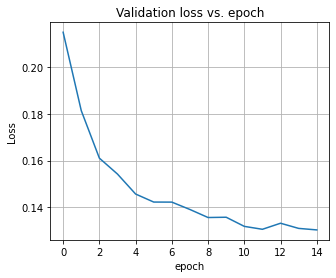

<Figure size 432x288 with 0 Axes>

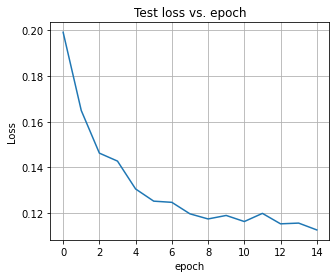

<Figure size 432x288 with 0 Axes>

In [0]:
if TrainMode:
  # plotting the results

  plt.figure(figsize=(5,4))
  plt.plot(np.array(val_loss_vec).T)
  plt.xlabel("epoch")
  plt.ylabel("Loss")
  plt.title("Validation loss vs. epoch")
  plt.grid()
  plt.show()
  plt.savefig("Val_loss_vs_epoch.png")

  plt.figure(figsize=(5,4))
  plt.plot(np.array(test_loss_vec).T)
  plt.xlabel("epoch")
  plt.ylabel("Loss")
  plt.title("Test loss vs. epoch")
  plt.grid()
  plt.show()
  plt.savefig("Test_loss_vs_epoch.png")

## Evaluation phase

### Filters and layers visualization

Here we visualize the feature maps and the filter patterns of several layers of our CNN model for some sample images.

In [0]:
# -------------------------------------------------------------
sample_idx_train = np.random.choice(np.arange(X_train.shape[0]),1)

X_batch = X_train[sample_idx_train, :, :, :]
X_batch_mean = np.mean(X_batch, axis=0)

conv_1_np, W1_np, W4_np = session.run([conv_1, W1, W4], feed_dict={x: X_batch, p_keep: 1.0})
conv_1_np_mean = np.mean(conv_1_np, axis=0)


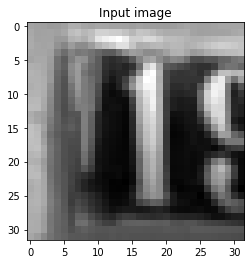

In [0]:
plt.imshow(X_batch_mean[:,:,0],'gray')
plt.title("Input image")
plt.show()


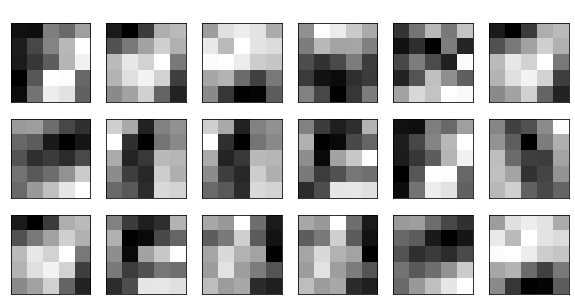

In [0]:
# Sample patterns of conv layer 1 filters
plot_sample_images(W1_np.transpose([3,0,1,2]),3,6)


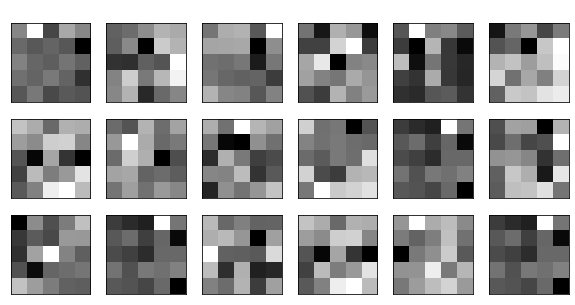

In [0]:
# Sample patterns of conv layer 4 filters
plot_sample_images(W4_np.transpose([3,0,1,2]),3,6)

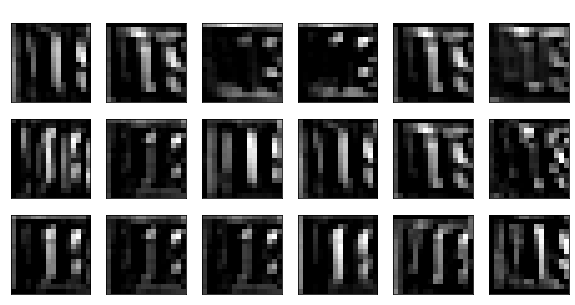

In [0]:
# Sample feature maps of conv layer 1
plot_sample_images(conv_1_np_mean.transpose([2,0,1]),3,6)


### Visual evaluation



Now we plot some mis-classified samples

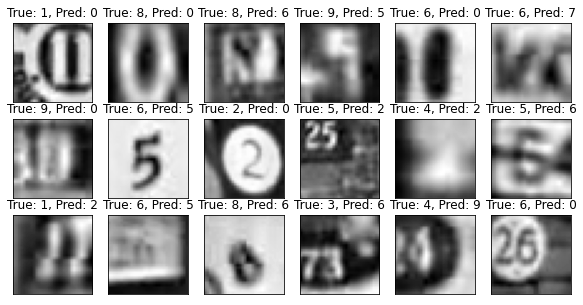

In [0]:
# Predictions on the test images
test_pred = session.run(y_pred_label, {x: X_test, y_true: y_test, p_keep: 1.0})

# Mis-classified samples
mis_classified = test_pred != np.argmax(y_test, axis=1)

images = X_test[mis_classified]
true_label = y_test[mis_classified]
pred_label = test_pred[mis_classified]

plot_sample_images(images, 3, 6, true_label, pred_label);

Below are the correctly classified samples

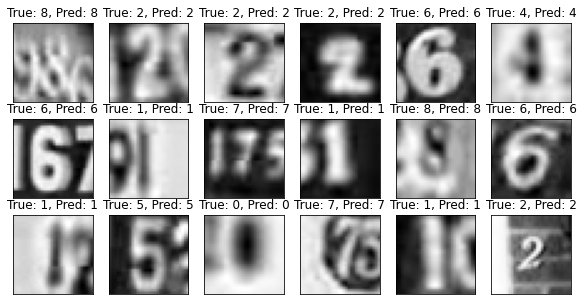

In [0]:
# Find the correct samples
correct = np.invert(mis_classified)

images = X_test[correct]
true_label = y_test[correct]
pred_label = test_pred[correct]

plot_sample_images(images, 3, 6, true_label, pred_label);

### Save the model

In [0]:
if TrainMode:  

  if os.path.exists(save_run_path):
    shutil.rmtree(save_run_path)

  shutil.copytree('ckpts', save_run_path)
  save_run_path


### Detection at different scales



Here instead of image pyramids we use different patch sizes based on different scales (we scale the window and slide it over the image)



In [0]:
def sliding_patch(img, patch_size= (32,32), stride_i=3, stride_j=3, scale=1.0):
    rows, cols = img.shape
    wi, wj = (int(scale * patch_size[0]),  int(scale * patch_size[1]))
    max_r = max(rows, wi)+stride_i
    max_c = max(cols,wj)+stride_j

    patches_list = list()
    indices = list()
    # padd the image with zeros of appropriate size
    img_padded = np.zeros((max_r,max_c), dtype= img.dtype)
    img_padded[:rows, :cols] = img

    for i in range(0, max_r - wi, stride_i):
        for j in range(0, max_c - wj, stride_j):
            patch = img_padded[i:i + wi, j:j + wj]
            if scale != 1:
                patch = cv2.resize(patch, (patch_size[1],patch_size[0]) )
            indices.append((i, j))
            patches_list.append(patch)
    return indices, patches_list
            

def convert_to_4d_array(data):
  n = len(data)
  d_shape = data[0].shape
  data_4d_array = np.zeros((n,d_shape[0],d_shape[1],1), dtype='float32')
  for i in range(n):
    data_4d_array[i,:,:,:] = np.expand_dims(data[i],2)
  return data_4d_array
  

In [0]:
import zipfile
import tarfile

def extract_file(path, extract_directory='.'):
    if path.endswith('.zip'):
        opener, mode = zipfile.ZipFile, 'r'
    elif path.endswith('.tar.gz') or path.endswith('.tgz'):
        opener, mode = tarfile.open, 'r:gz'
    elif path.endswith('.tar.bz2') or path.endswith('.tbz'):
        opener, mode = tarfile.open, 'r:bz2'
    else: 
        raise (ValueError, "Could not extract `%s` as no appropriate extractor is found" % path)

    cwd = os.getcwd()
    os.chdir(extract_directory)

    try:
        file = opener(path, mode)
        try: file.extractall()
        finally: file.close()
    finally:
        os.chdir(cwd)
        

In [0]:
# # Download image files
# image_folder = '/Data_format1/'
# PATH = os.path.abspath('.') + image_folder 
# if not os.path.exists(PATH+'/train/'):

#   image_zip = tf.keras.utils.get_file('train.tar.gz',
#                                       cache_subdir=PATH,
#                                       origin = 'http://ufldl.stanford.edu/housenumbers/train.tar.gz',
#                                       extract = False)


In [0]:
# zip_path = '/content/Data_format1/train.tar.gz'
img_folder = '/train/'
zip_path = '/content/drive/My Drive/Colab Notebooks/ComputerVision/HW3/Data/Data_format1/train.tar.gz'
zip_extract_path = os.path.abspath('.')
if not os.path.exists(zip_extract_path+img_folder):
  extract_file(zip_path, zip_extract_path)
  

In [0]:
import glob
img_names = glob.glob(zip_extract_path+img_folder+'*.png')


In [0]:
chosen_images = np.random.choice(img_names,5)
chosen_images

array(['/content/train/26091.png', '/content/train/29902.png',
       '/content/train/25944.png', '/content/train/26737.png',
       '/content/train/26261.png'], dtype='<U24')

In [0]:
chosen_images = ['/content/train/139.png', '/content/train/28969.png',
       '/content/train/27223.png', '/content/train/25189.png',
       '/content/train/21774.png']


## Find digits in test images 

We search though different scales to find digits in test images.

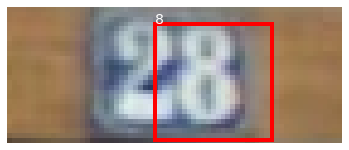

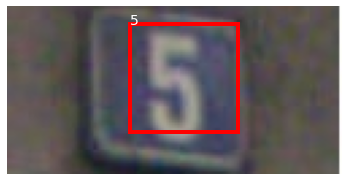

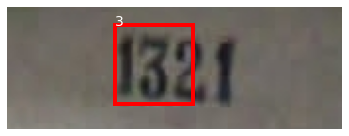

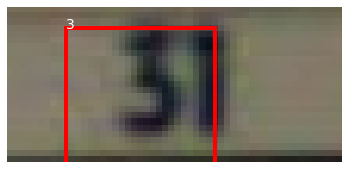

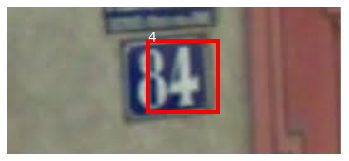

In [0]:
best_scale_index_list = []
best_scores_list = []
best_indices_list = []
best_patches_list = []

patch_size= (32,32)

scales = [0.75, 1.25, 1.75, 2.25]
for img_name in chosen_images:
  img_rgb = cv2.imread(img_name)  
  img = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2GRAY)
  img_rgb = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2RGB)
  
  all_indices = []
  all_patches = []
  all_scores =[]

  max_scores_all = np.zeros(len(scales),dtype='float32')

  for i,s in enumerate(scales):
    indices, patches = sliding_patch(img, patch_size, scale = s)
    patches_array = convert_to_4d_array(patches)
    patches_array = (patches_array - X_train_mean) / X_train_std
    scores = session.run(fc_2, {x: patches_array, p_keep: 1.0})
    all_scores.append(scores)
    # max_scores_dim1 = np.max(scores, axis=1)
    # max_scores_all[i] = np.sum(max_scores_dim1.argsort()[-2:]) 
    max_scores_all[i] = np.max(scores) # the best scale yields the highest max score 
    all_patches.append(patches)
    all_indices.append(indices)
  
  


  best_scale_index = np.argmax(max_scores_all)
  scores = all_scores[best_scale_index]
  indices = all_indices[best_scale_index]
  patches = all_patches[best_scale_index]

  best_scale_index_list.append(best_scale_index)
  best_scores_list.append(scores)
  best_indices_list.append(indices)
  best_patches_list.append(patches)

   
  fig, ax = plt.subplots()
  ax.imshow(img_rgb)
  ax.axis('off')

  Ni, Nj = tuple((scales[best_scale_index] * np.array(patch_size)).astype(int))
  indices = np.array(indices)

  pred_digits = np.argmax(scores, axis = 1)
  scores_max = np.max(scores, axis=1)
  best_digit_id = np.argmax(scores_max)

  i, j = indices[best_digit_id]
  ax.add_patch(plt.Rectangle((j, i), Nj, Ni, edgecolor='red',
                               alpha=1, lw=4, facecolor='none'))
  ax.text(j,i,pred_digits[best_digit_id], fontsize=14, color= 'w')
 

In [0]:
best_scale_index_list

[0, 1, 1, 0, 2]

### Non-maximum supression
Here we use ``tf.image.non_max_suppression`` method from Tensorflow module to filter non-maximum selections.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


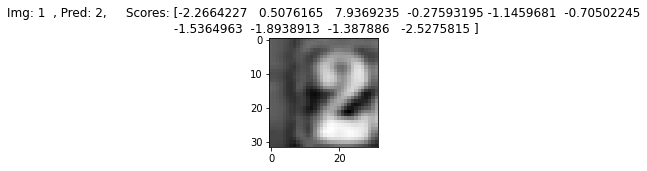

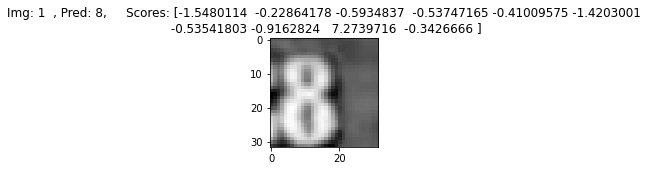

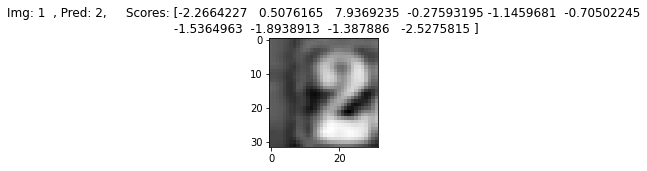

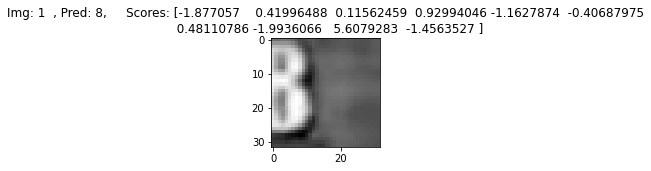

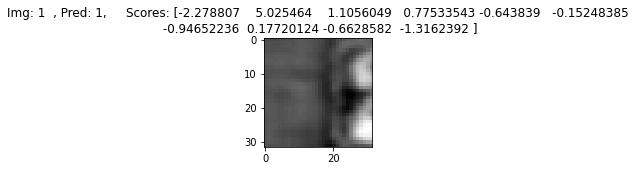

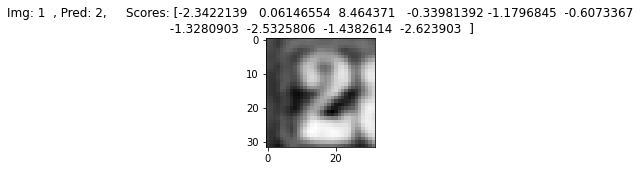

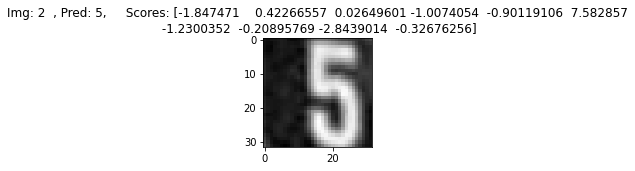

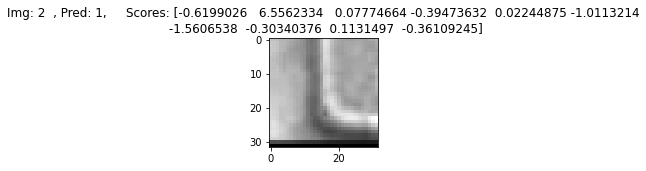

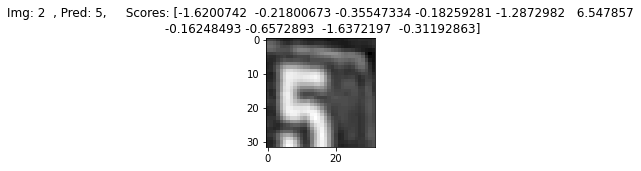

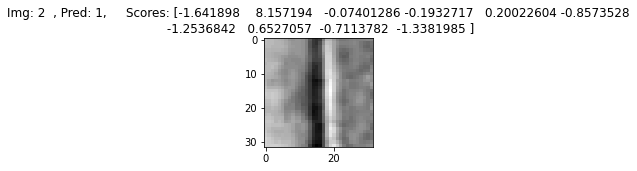

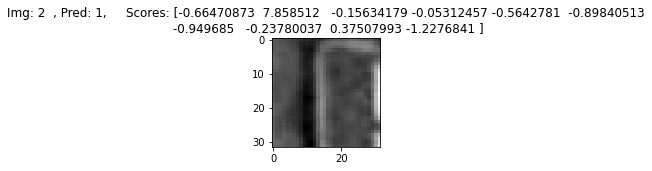

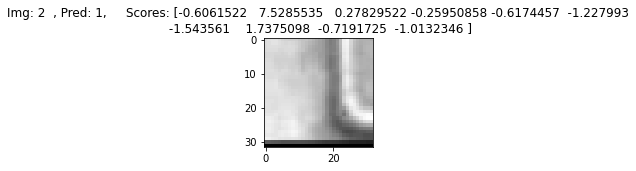

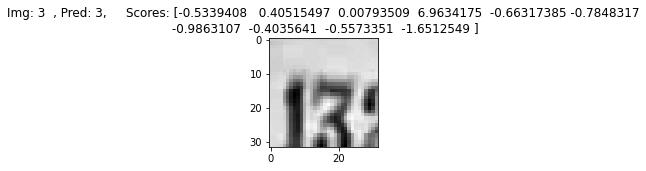

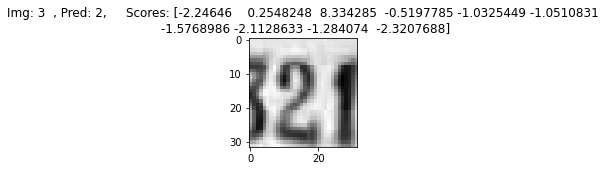

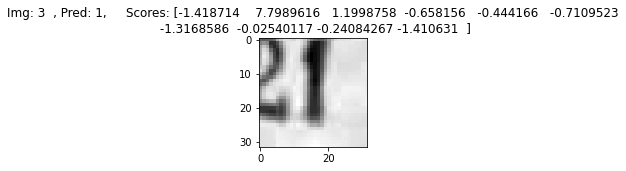

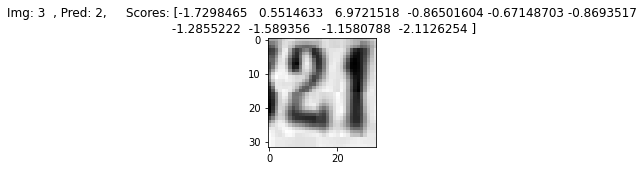

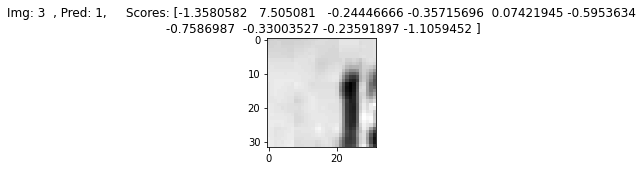

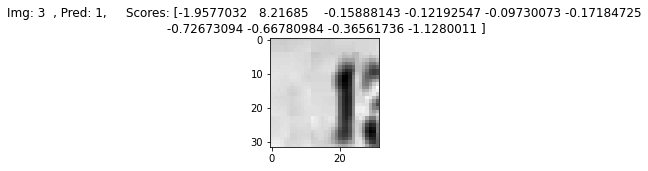

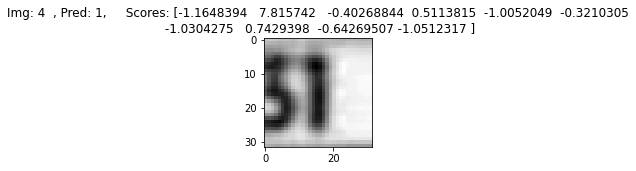

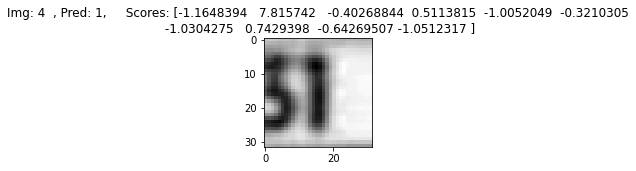

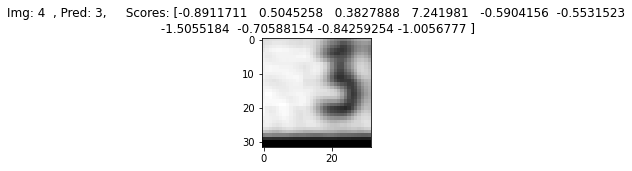

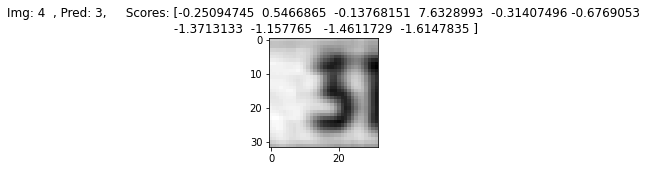

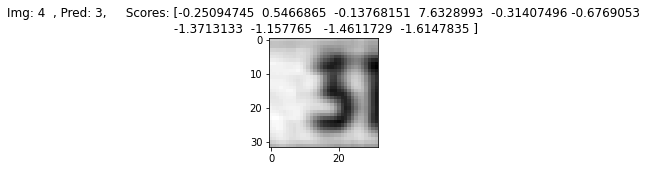

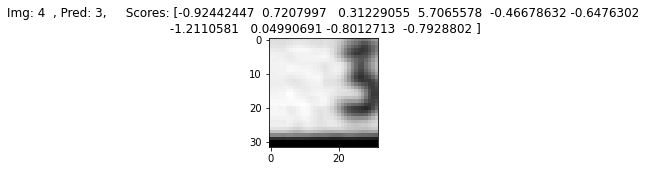

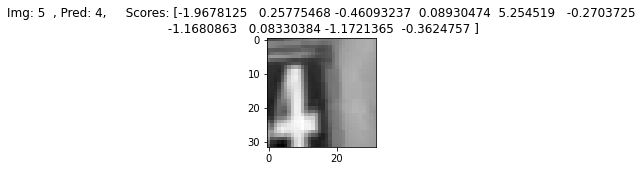

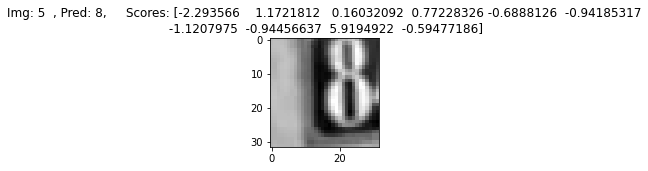

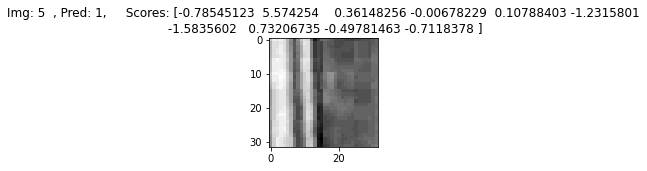

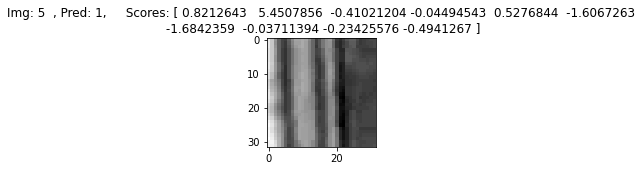

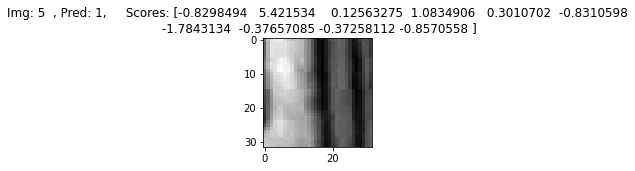

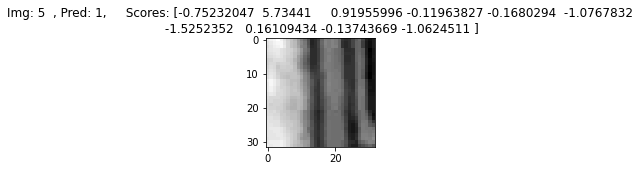

In [0]:

for img_id, img_name in enumerate(chosen_images):
  img_rgb = cv2.imread(img_name)  
  img = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2GRAY)
  img_rgb = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2RGB)
  
  scale = scales[best_scale_index_list[img_id]]
  scores = best_scores_list[img_id]
  indices = best_indices_list[img_id]
  indices = np.array(indices)
  patches = best_patches_list[img_id]

  pred_digits = np.argmax(scores, axis = 1)
  scores_max = np.max(scores, axis=1)

 
  # rnd_idx = np.random.permutation(len(patches))
  # rnd_idx = rnd_idx[:10]

  all_idx = np.arange(len(patches))
  good_idx = all_idx[scores_max > 5]
  if len(good_idx)>0:
    good_idx = np.random.choice(good_idx,6)
    for id in good_idx:
      patch = patches[id]
      plt.figure(figsize=(2,2))
      plt.imshow(patch, 'gray')
      plt.title('Img: '+ str(img_id+1)+ '  , Pred: '+ str(pred_digits[id])+ ',     Scores: '+str(scores[id,:]))

 


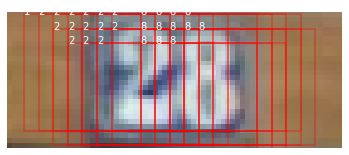

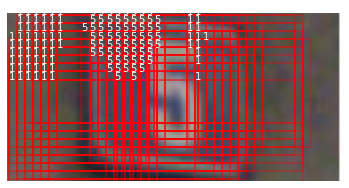

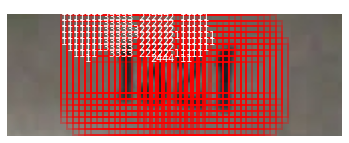

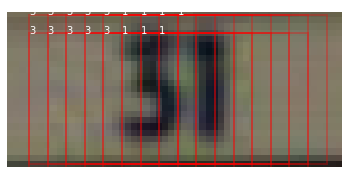

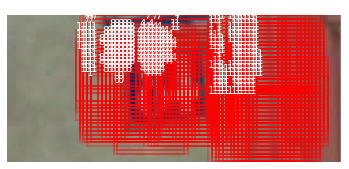

In [0]:

for img_id, img_name in enumerate(chosen_images):
  img_rgb = cv2.imread(img_name)  
  img = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2GRAY)
  img_rgb = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2RGB)
  
  scale = scales[best_scale_index_list[img_id]]
  scores = best_scores_list[img_id]
  indices = best_indices_list[img_id]
  indices = np.array(indices)
  patches = best_patches_list[img_id]



  Ni, Nj = tuple((scale * np.array(patch_size)).astype(int))
  

  fig, ax = plt.subplots()
  ax.imshow(img_rgb)
  ax.axis('off')

  # scores[scores<0.5] = 0 
  pred_digits = np.argmax(scores, axis = 1)
  scores_max = np.max(scores, axis=1)
  best_digit_idx = scores_max>5
  best_digit_labels = pred_digits[best_digit_idx]

  for k,(i, j) in enumerate(indices[best_digit_idx]):
      ax.add_patch(plt.Rectangle((j, i), Nj, Ni, edgecolor='red',
                                alpha=0.3, lw=2, facecolor='none'))
      ax.text(j,i,best_digit_labels[k], color= 'w')

In [0]:
from matplotlib import colors as mcolors


colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)
colors_list = list(colors.keys())

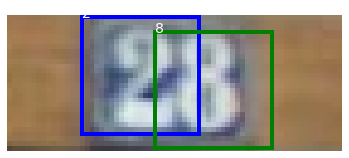

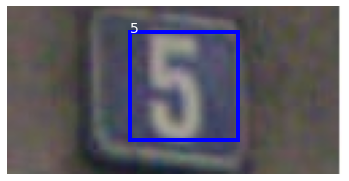

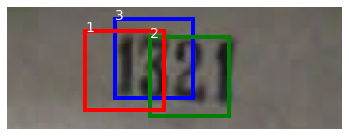

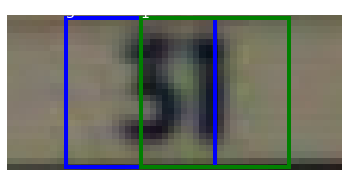

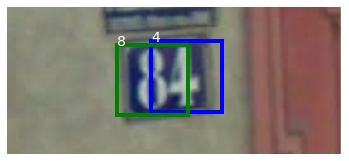

In [0]:

for img_id, img_name in enumerate(chosen_images):
  img_rgb = cv2.imread(img_name)  
  img = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2GRAY)
  img_rgb = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2RGB)
  
  scale = scales[best_scale_index_list[img_id]]
  scores = best_scores_list[img_id]
  indices = best_indices_list[img_id]
  indices = np.array(indices)

  scores_max = np.max(scores, axis=1)
  pred_digits = np.argmax(scores, axis = 1)
  
  sorted_scores_idx =  np.argsort(scores_max, axis = 0)

  
  # N_best = 60
  # indices = indices[sorted_scores_idx[-N_best:-1],:]
  # scores_max = scores_max[sorted_scores_idx[-N_best:-1]]
  # pred_digits = pred_digits[sorted_scores_idx[-N_best:-1]]

  Ni, Nj = tuple((scale * np.array(patch_size)).astype(int))
  boxes = np.zeros((indices.shape[0],4))

  for k, (i, j) in enumerate(indices):
    boxes[k,0] = j
    boxes[k,1] = i
    boxes[k,2] = j+Nj
    boxes[k,3] = i+Ni
        

  boxes_tf = tf.convert_to_tensor(boxes, dtype=tf.float32)
  scores_max_tf = tf.convert_to_tensor(scores_max, dtype=tf.float32)
  
  thr = 0.75*np.max(scores_max) 

  selected_indices = tf.image.non_max_suppression(
    boxes_tf, scores_max_tf, 3, iou_threshold=0.45,
    score_threshold=thr.astype('float32'), name=None
  )
  # selected_boxes_tf = tf.gather(boxes_tf, selected_indices)
  
  supressed_indices = session.run(selected_indices)
  
  fig, ax = plt.subplots()
  ax.imshow(img_rgb)
  ax.axis('off')

  if len(supressed_indices)>0:
    best_digit_labels = pred_digits[supressed_indices]
    best_scores = scores_max[supressed_indices]

    for k, (i, j) in enumerate(indices[supressed_indices]):
        ax.add_patch(plt.Rectangle((j, i), Nj, Ni, edgecolor= colors_list[k],
                                  alpha=1, lw=4, facecolor='none'))
        ax.text(j,i,best_digit_labels[k], fontsize=14, color= 'w')